## House Prices Regression

The aim of the project was to predict house prices. Due to specific data set (small amount of records, many features), appropriate regression techniques should be taken into consideration. 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
from ml_metrics import rmsle, rmse
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.preprocessing import CategoricalEncoder, OneHotEncoder 

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 400)

### Data loading and exploratoty data analysis

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
993,994,60,RL,68.0,8846,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,750,750,GasA,Ex,Y,SBrkr,750,750,0,1500,0,0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2005.0,RFn,2,564,TA,TA,Y,0,35,0,0,0,0,NaN,NaN,NaN,0,8,2006,New,Partial,173900
577,578,80,RL,96.0,11777,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,SLvl,5,6,1966,1966,Gable,CompShg,VinylSd,VinylSd,BrkFace,97.0,TA,TA,CBlock,TA,TA,Av,LwQ,328,ALQ,551,285,1164,GasA,Ex,Y,SBrkr,1320,0,0,1320,1,0,1,0,3,1,TA,6,Typ,2,Fa,Attchd,1966.0,RFn,2,564,TA,TA,Y,160,68,240,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Abnorml,164500
366,367,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD,Normal,159000
236,237,20,RL,65.0,8773,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,98.0,Gd,TA,PConc,Gd,TA,Av,GLQ,24,Unf,0,1390,1414,GasA,Ex,Y,SBrkr,1414,0,0,1414,0,0,2,0,3,1,Gd,6,Typ,0,NaN,Attchd,2004.0,RFn,2,494,TA,TA,Y,132,105,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,185500
394,395,50,RL,60.0,10134,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,5,6,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,735,735,GasA,Gd,Y,FuseA,735,299,0,1034,0,0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1940.0,Unf,1,240,TA,TA,Y,0,39,0,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,109000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
train.isnull().sum().sort_values(ascending=False).head(25)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
YearRemodAdd       0
MSSubClass         0
Foundation         0
ExterCond          0
ExterQual          0
dtype: int64

There is not a lot of records available (1460 in test set). On the other hand there are many different features (about 80). 
Some features contain a lot of null values. There are both categorical and continuous features

### Histograms

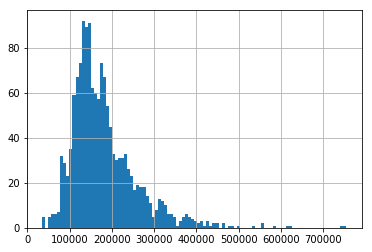

In [8]:
train['SalePrice'].hist(bins=100)

Distribution of target variable is skewed. Logarithmic transformation may be helpful.

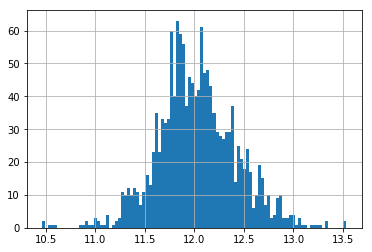

In [9]:
np.log1p(train['SalePrice']).hist(bins=100)

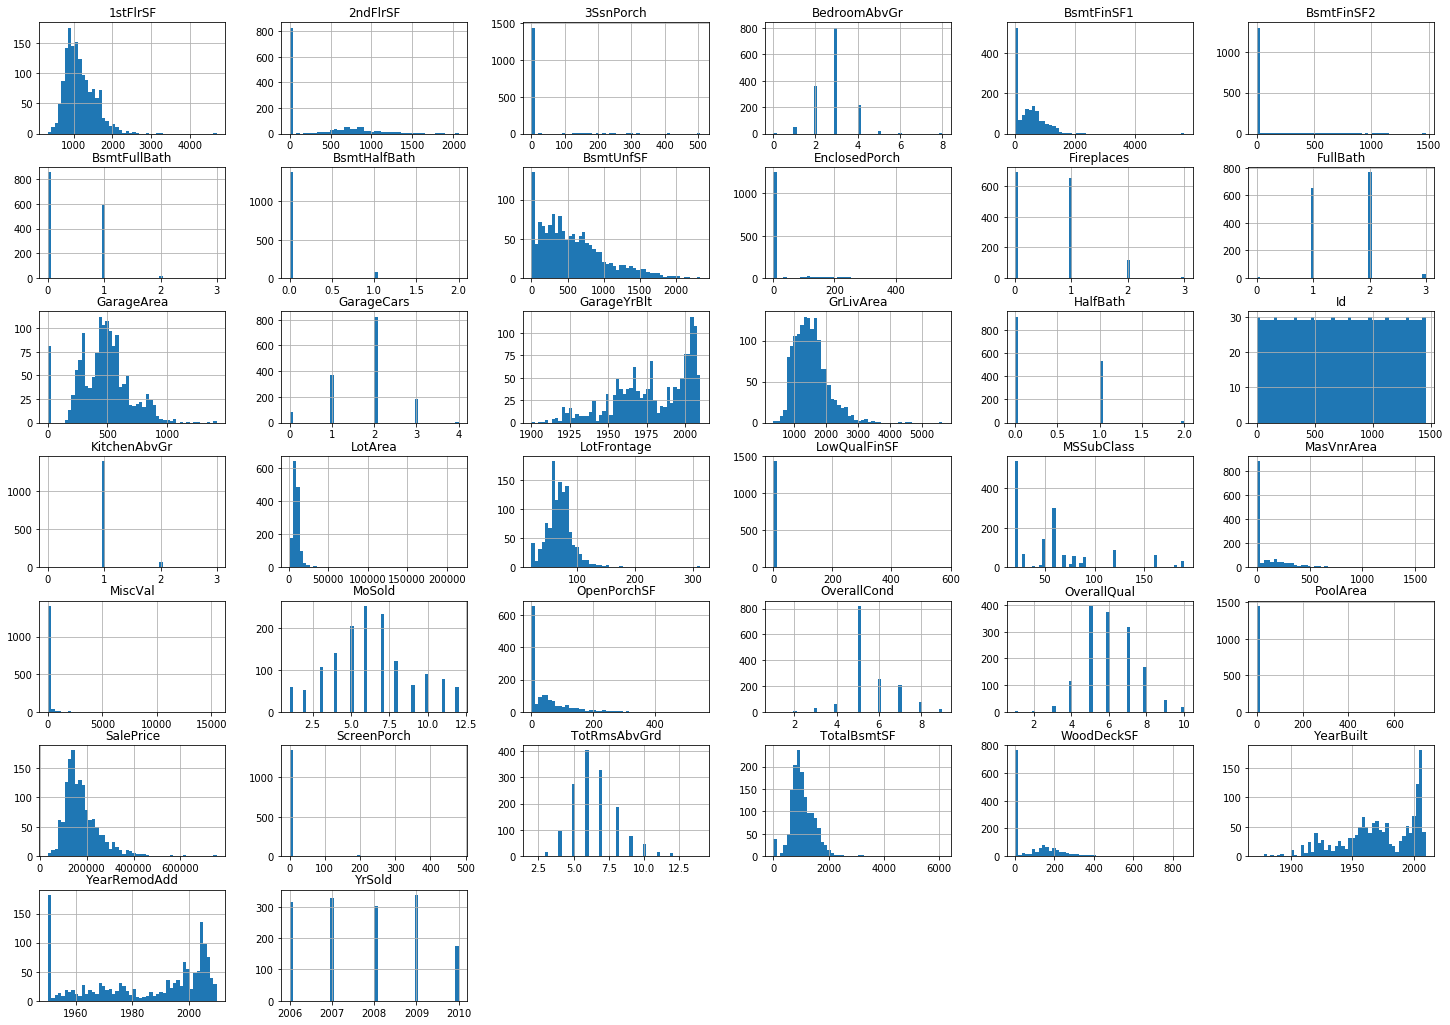

In [10]:
train.hist(bins=50, figsize=(25,18))
plt.show()

Continuous features are skewed, transformations like logarithmic or box cox should be implemented.

### Correlations

In [11]:
corr_matrix = train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

There is very strong correlation for some features like 'OverallQual', 'GrLivArea','GarageCars','GarageArea', 'TotalBsmtSF', '1stFlrSF'. 
Let's look closer on these features.

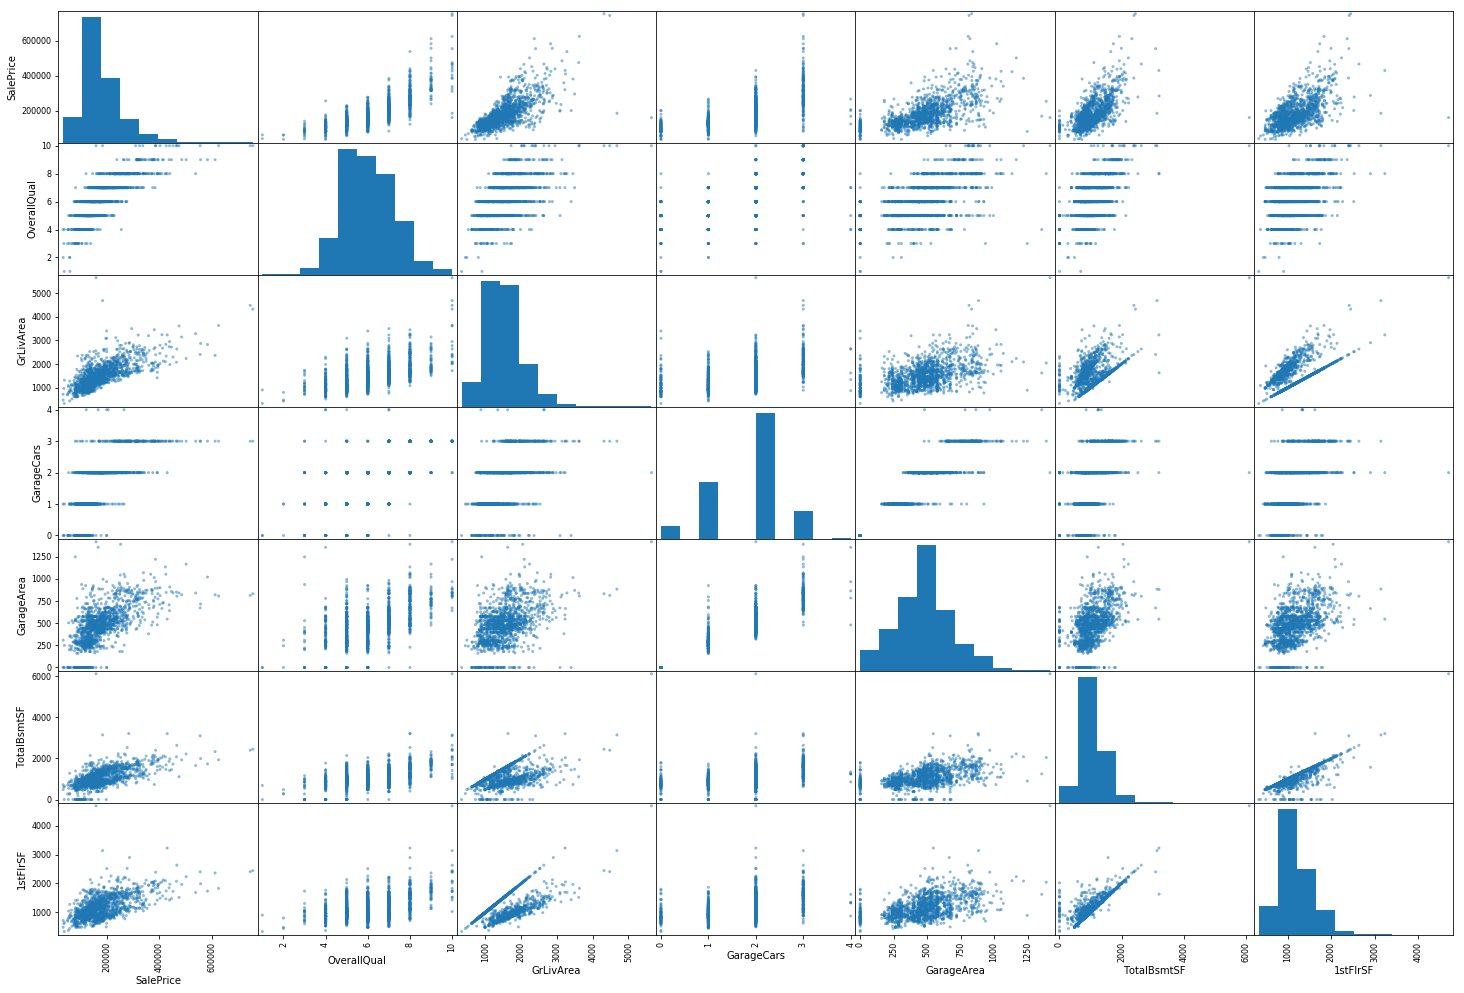

In [12]:
attributes = ['SalePrice',    
             'OverallQual',    
             'GrLivArea',
             'GarageCars',
             'GarageArea',
             'TotalBsmtSF',
             '1stFlrSF' ]

scatter_matrix(train[attributes], figsize=(25, 17))
plt.show()

Taking into consideration strong linearity I've tried to remove outliers. Below there is example for GrLivArea feature. For other features I've decided not to remove oultiers due to lack of impact on final result.

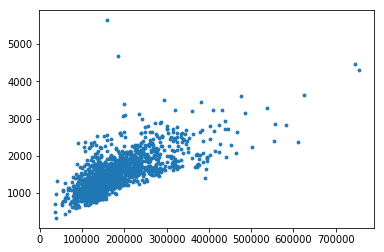

In [13]:
plt.scatter(train['SalePrice'], train['GrLivArea'], s=8)

There are extremaly high values of price and live area which may disturb models.

In [14]:
train[train['SalePrice']>600000]['SalePrice']

691     755000
898     611657
1169    625000
1182    745000
Name: SalePrice, dtype: int64

In [15]:
train[train['GrLivArea']>4000]['GrLivArea']

523     4676
691     4316
1182    4476
1298    5642
Name: GrLivArea, dtype: int64

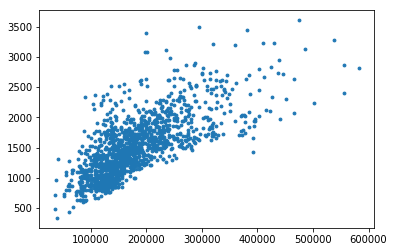

In [16]:
train_out = train[train['SalePrice']<600000].copy()
train_out = train_out[train_out['GrLivArea']<4000]

plt.scatter(train_out['SalePrice'], train_out['GrLivArea'], s=8)

After removing outliers scatter plot looks like more linear.

### Features analysis

In [17]:
train[train["PoolArea"]>0][["PoolArea","SalePrice"]]

,PoolArea,SalePrice
197,512,235000
810,648,181000
1170,576,171000
1182,555,745000
1298,480,160000
1386,519,250000
1423,738,274970


There are only few observations with not null values. As it can be seen below one of those may be treated as outlier.

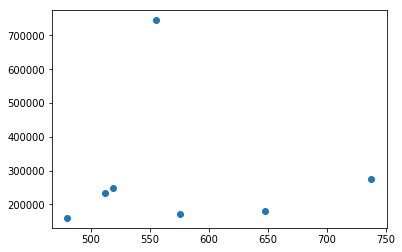

In [18]:
plt.scatter(train[train["PoolArea"]>0]["PoolArea"],train[train["PoolArea"]>0]["SalePrice"])

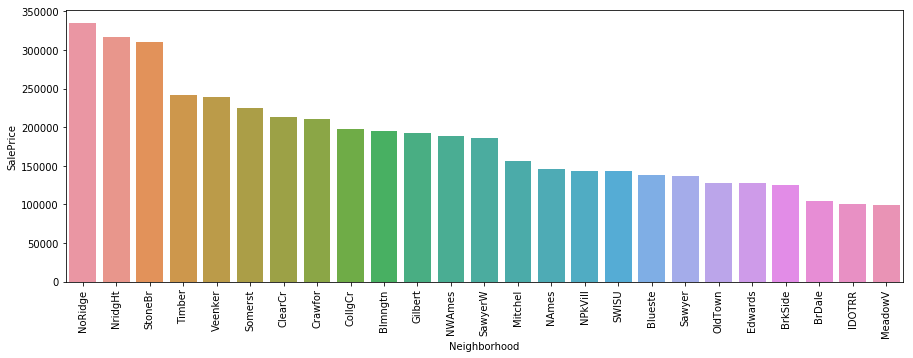

In [19]:
street_price = train[['Neighborhood', 'SalePrice']].groupby('Neighborhood').agg(
    np.mean).reset_index().sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(15, 5))
sns.barplot(x='Neighborhood', y="SalePrice", data=street_price)
plt.xticks(rotation=90)

Mean of price is significantly higher for some streets. This feature may be important.

In [20]:
train['Neighborhood'].value_counts(dropna=False)

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [21]:
train[train['GarageQual']!=train['GarageCond']][['GarageQual','GarageCond']].shape[0]

140

In [22]:
train[train['GarageQual']!=train['GarageCond']][['GarageQual','GarageCond']].sample(10)

,GarageQual,GarageCond
1337,NaN,NaN
127,NaN,NaN
976,NaN,NaN
635,NaN,NaN
998,TA,Fa
30,TA,Fa
375,NaN,NaN
568,Gd,TA
1143,NaN,NaN
1380,TA,Fa


In [23]:
print(train['SaleCondition'].value_counts(dropna=False)) 

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64


In [24]:
train['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [25]:
train['Condition2'].value_counts()

Norm      1445
Feedr        6
RRNn         2
PosN         2
Artery       2
RRAe         1
PosA         1
RRAn         1
Name: Condition2, dtype: int64

In [26]:
train[(train['Condition1']!='Norm') & (train['Condition2']!='Norm')][['Condition1','Condition2']]

,Condition1,Condition2
9,Artery,Artery
29,Feedr,RRNn
63,RRAn,Feedr
88,Feedr,Feedr
184,RRAn,Feedr
523,PosN,PosN
531,RRNn,Feedr
548,Feedr,RRNn
583,Artery,PosA
589,RRAn,Feedr


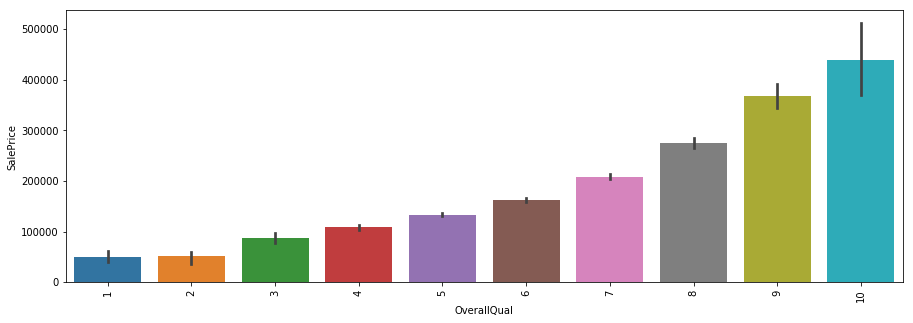

In [27]:
plt.figure(figsize=(15, 5))
sns.barplot(x='OverallQual', y="SalePrice",  data=train)
plt.xticks(rotation=90);

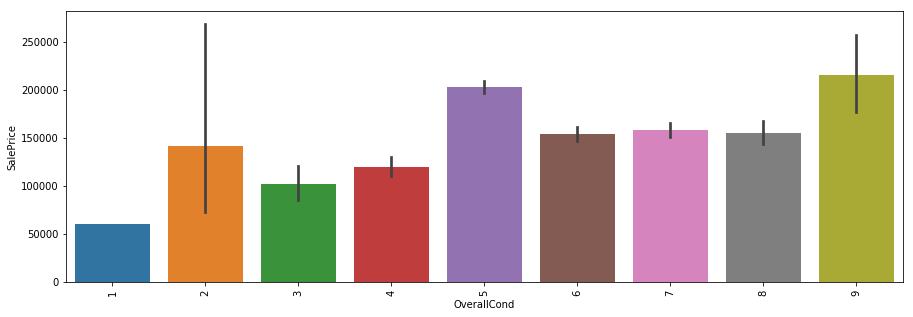

In [28]:
plt.figure(figsize=(15, 5))
sns.barplot(x='OverallCond', y="SalePrice", data=train)
plt.xticks(rotation=90);

In [29]:
train['Utilities'].value_counts(dropna=False)

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [30]:
train['Fence'].value_counts(dropna=False)

NaN      1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64

### Data transforming using pipelines

In [32]:
def remove_outliers(df, sale_thr=600000, area_thr=4000): 
    df = df[df['SalePrice']<sale_thr]
    df = df[df['GrLivArea']<area_thr]  
    return df_train

In [33]:
def missing_values(X_all):

    X_all['MSSubClass'] = X_all['MSSubClass'].apply(str)
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'):
        X_all[col] = X_all[col].fillna(0)
        
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        X_all[col] = X_all[col].fillna(0)
        
    X_all["LotFrontage"] = X_all.groupby(
        "Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
    X_all['MSZoning'] = X_all['MSZoning'].fillna(X_all['MSZoning'].mode()[0])
    X_all["Functional"] = X_all["Functional"].fillna("Typ")
    X_all['Electrical'] = X_all['Electrical'].fillna(
        X_all['Electrical'].mode()[0])
    X_all['KitchenQual'] = X_all['KitchenQual'].fillna(
        X_all['KitchenQual'].mode()[0])
    X_all['Exterior1st'] = X_all['Exterior1st'].fillna(
        X_all['Exterior1st'].mode()[0])
    X_all['Exterior2nd'] = X_all['Exterior2nd'].fillna(
        X_all['Exterior2nd'].mode()[0])
    X_all['SaleType'] = X_all['SaleType'].fillna(X_all['SaleType'].mode()[0])

    return X_all

In [34]:
def label_encoding(X_all): 
    
    cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 
            'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'BsmtExposure', 'OverallCond', 'YrSold', 'MoSold'] 
    
    for col in cols:
        label_enc = LabelEncoder() 
        X_all[col] = label_enc.fit_transform(list(X_all[col].values))
        
    return X_all

In [35]:
def feat_eng(X_all):

    positive = ['PosN', 'PosA']
    negative = ['Artery', 'Feedr', 'RRNn', 'RRAn', 'RRNe', 'RRAe']
    normal = ['Norm']
    exp_street = ['NoRidge', 'NridgHt', 'StoneBr']

    X_all = X_all.drop(['Utilities'], axis=1)

    X_all['Has_Poll'] = X_all["PoolArea"].map(lambda x: 1 if x > 0 else 0)
    X_all['Cond_Positive'] = X_all.apply(lambda x: 1 if (
        x['Condition1'] in positive) | (x['Condition2'] in positive) else 0, axis=1)
    X_all['Cond_Negative'] = X_all.apply(lambda x: 1 if (
        x['Condition1'] in negative) | (x['Condition2'] in negative) else 0, axis=1)
    
    X_all['Exp_Street'] = X_all.apply(
        lambda x: 1 if x['Neighborhood'] in exp_street else 0, axis=1)
    
    X_all['Remod'] = X_all.apply(
        lambda x: 1 if x['YearRemodAdd'] != x['YearBuilt'] else 0, axis=1)
    
    X_all['Total_SF'] = X_all['TotalBsmtSF'] + \
        X_all['1stFlrSF'] + X_all['2ndFlrSF']
    X_all['Total_Bathrooms'] = (X_all['FullBath'] + (0.5 * X_all['HalfBath']) +
                                X_all['BsmtFullBath'] + (0.5 * X_all['BsmtHalfBath']))
    X_all['Total_Porch_SF'] = (X_all['OpenPorchSF'] + X_all['3SsnPorch'] +
                               X_all['EnclosedPorch'] + X_all['ScreenPorch'] + X_all['WoodDeckSF'])

    X_all = X_all.fillna(-1)
    
    return X_all

In [36]:
def skewness(X_all):
    numeric_feats = X_all.dtypes[X_all.dtypes!="object"].index    
    skewed_feats = X_all[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewed_feats = skewed_feats[abs(skewed_feats)>0.0].index
    
    lam = 0.15
    for feat in skewed_feats:
        X_all[feat] = boxcox1p(X_all[feat], lam)
        
    return X_all

In [37]:
def num_feats(X_all): 
    X_num = [x for x in X_all.select_dtypes(include=['float', 'int64']) ]
    
    return X_all[X_num]

In [38]:
def cat_feats(X_all):   
    X_cat = [x for x in X_all.select_dtypes(include=['object']) ]
    
    for feat in X_cat:
        X_all[feat] = X_all[feat].astype(str) 
        
    return X_all[X_cat]

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

class DFTransform(TransformerMixin, BaseEstimator):
    
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy  
        
    def fit(self, *_):
        return self
    
    def transform(self, X1):
        X_ = X1 if not self.copy else X1.copy()
        return self.func(X_)

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

test = df_test[['Id']].copy()

In [ ]:
train_pipeline = Pipeline([
    ('remove outliers', DFTransform(lambda df: remove_outliers(df))),]),

df_train = train_pipeline[0].fit_transform(df_train)

In [ ]:
y_train = df_train.loc[:, ['SalePrice']].values.copy()

df_train = df_train.drop(['SalePrice', 'Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

X_all = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
pre_pipeline = Pipeline([
    ('missing_values', DFTransform(lambda df: missing_values(df))),
    ('label_encoding', DFTransform(lambda df: label_encoding(df))),
    ('feature_eng', DFTransform(lambda df: feat_eng(df))),
    ('skewness', DFTransform(lambda df: skewness(df))),
]),

X_all = pre_pipeline[0].fit_transform(X_all)

In [39]:
num_pipeline = Pipeline([
    ('selector_num', DFTransform(lambda df: num_feats(df))),
    ('scaler_num',  RobustScaler()),
]),

cat_pipeline = Pipeline([
    ('selector_cat', DFTransform(lambda df: cat_feats(df))),
    ('cat_encoder', OneHotEncoder(sparse=False, categorical_features='all')),
]),

union_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline[0]),
    ("cat_pipeline", cat_pipeline[0]),
]),

X_all = union_pipeline[0].fit_transform(X_all)
y_log = np.log1p(y_train)

train_eng = X_all[0:df_train.shape[0]]
test_eng = X_all[df_train.shape[0]:]

print('full shape: ', X_all.shape)
print('train shape: ', train_eng.shape)
print('test shape: ', test_eng.shape)

full shape:  (2919, 265)
train shape:  (1460, 265)
test shape:  (1459, 265)


### Validation of models

Model's hiperparameters have been found using hyperopt.

In [40]:
def rmse_cv(model, X, y, cv=5):  
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv)
    rmse_scores = np.sqrt(-scores)
    
    mean = np.round(rmse_scores.mean(),5)
    std = np.round(rmse_scores.std(),5)  
    
    return rmse_scores, mean, std

In [41]:
results = {}

models = [RandomForestRegressor(random_state=2019, n_estimators=220, max_depth=8),
          GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                    min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=2019),
          xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3,
                           min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571,
                           subsample=0.5213, silent=1, random_state=2019),
          Lasso(random_state=2019, max_iter=1e7, alpha=0.0004),
          KernelRidge(alpha=0.7, kernel='polynomial', degree=2, coef0=5.5),
          ElasticNet(random_state=2019, max_iter=1e7, alpha=0.0004, l1_ratio=0.9), ]

for i in models:
    x, y, z = rmse_cv(i, train_eng, y_log.ravel(), cv=5)
    
    print(type(i).__name__)
    print("mean: ", y, "std: ", z)
    
    results[type(i).__name__] = y

RandomForestRegressor
mean:  0.14378 std:  0.00763
GradientBoostingRegressor
mean:  0.12251 std:  0.01165
XGBRegressor
mean:  0.12182 std:  0.0099
Lasso
mean:  0.12462 std:  0.01652
KernelRidge
mean:  0.13044 std:  0.01354
ElasticNet
mean:  0.12481 std:  0.01658


In [42]:
results 

{'ElasticNet': 0.12481,
 'GradientBoostingRegressor': 0.12251,
 'KernelRidge': 0.13044,
 'Lasso': 0.12462,
 'RandomForestRegressor': 0.14378,
 'XGBRegressor': 0.12182}

Relatively simple algorithms like ElasticNet, Lasso achieve comparable or even better results than complicated models, like for example XGBoost. It gives evidences that sometimes it is worth considering to simplify solution, what may result in better performance without loose of model's quality.

#### Preparing test data for kaggle validation

In [43]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=2019)

Xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                           learning_rate=0.05, max_depth=3,
                           min_child_weight=1.7817, n_estimators=2200,
                           reg_alpha=0.4640, reg_lambda=0.8571,
                           subsample=0.5213, silent=1,
                           random_state=2019)

lasso = Lasso(random_state=2019, max_iter=1e7, alpha=0.0004)

ENet = ElasticNet(random_state=2019, max_iter=1e7, alpha=0.0004, l1_ratio=0.9)

models = [GBoost, Xgboost, lasso, ENet]

In [44]:
def model_avg(models, X_train, y_train, X_test, test):    
    for i, model in enumerate(models):
        model.fit(X_train, y_train.ravel())
        
        feat = "SalePrice" + str(i+1)
        test[feat] = np.expm1(model.predict(X_test))
        
    return test

In [45]:
test = model_avg(models, train_eng, y_log, test_eng, test)

In [46]:
test["SalePrice_avg"] = (test["SalePrice1"]+test["SalePrice2"] +
                         test["SalePrice3"]+test["SalePrice4"]) / len(models)
test[["Id", "SalePrice_avg"]].to_csv('stack_pip.csv', index=False)